<a href="https://colab.research.google.com/github/IorioDiego/SOA-HPC/blob/master/HPC/Cuaderno_1_Miercoles__grupo11_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---
# 1 Introducción




### Especificación del entorno 

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-a995a51f-032b-e20d-21c7-fbbccac3dec4)


In [ ]:
!cd  /usr/local/cuda/samples/1_Utilities/deviceQuery/; make >/dev/null
!/usr/local/cuda/samples/1_Utilities/deviceQuery/deviceQuery | grep "Max dimension"

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)


In [ ]:
!cd  /usr/local/cuda/samples/1_Utilities/deviceQuery/; make >/dev/null
!/usr/local/cuda/samples/1_Utilities/deviceQuery/deviceQuery | grep Maximum

  Maximum Texture Dimension Size (x,y,z)         1D=(65536), 2D=(65536, 65536), 3D=(4096, 4096, 4096)
  Maximum Layered 1D Texture Size, (num) layers  1D=(16384), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(16384, 16384), 2048 layers
  Maximum number of threads per multiprocessor:  2048
  Maximum number of threads per block:           1024
  Maximum memory pitch:                          2147483647 bytes


###Sobel Filter

El Sobel Filter permite detectar los bordes de una imagenes valiendose de 2 matrices que utiliza para determinar el gradiente correspondiente a cada Piexel(Gx para direcciones horizontales y Gy para verticales)

Mx =  { [ -1  -2    -1] 
        [ 0    0     0]
        [ 1    2     1] }

My =  { [ -1  0  1] 
        [ -2  0  2 ]
        [ -1  2  1] } 

El gradiente se calcula a partir de : 

G(x,y) = sqrt( Gx^2 + Gy^2 )








                                    


---
# 2 Armado del ambiente
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [2]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg



--2021-11-23 01:27:03--  https://justin-liang.com/tutorials/canny/images/3_gaussian.jpg?raw=true
Resolving justin-liang.com (justin-liang.com)... 204.44.192.35
Connecting to justin-liang.com (justin-liang.com)|204.44.192.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22970 (22K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>]  22.43K  --.-KB/s    in 0.05s   

2021-11-23 01:27:03 (485 KB/s) - ‘imagen.jpg’ saved [22970/22970]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [74]:
!pip install pycuda

---
# 3.1 Desarrollo GPU


Imagen del filtro: imagen.jpg -L- [480, 480]
Thread: [ 16 , 19  ], Bloque : [ 30 , 26 ]
Total de Thread: [ 480 , 494  ]  =  237120
Tiempo TOTAL:  63.679 [ms]
Tiempo GPU  :  0.183 [ms]


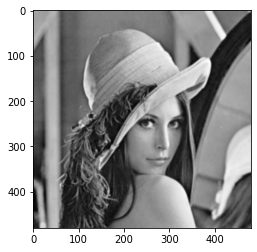

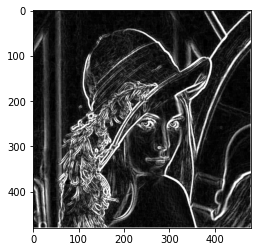

In [82]:
%matplotlib inline
from datetime import datetime
tiempo_total_GPU = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 

try:
  import pycuda.driver as cuda
except ModuleNotFoundError:
  print("No tiene el modulo cuda instalado, se instalará a continuacion")
  !pip install pycuda
  import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule


# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )


# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
__global__ void kernel_img( int ancho, int alto, int *img_O, int  *img_R )
{

    int col = blockIdx .x * blockDim .x + threadIdx .x;
  int row = blockIdx .y * blockDim .y + threadIdx .y;

  if( col < ancho && row < alto){ // alto/2 para mitad superior
                                    //row > alto/2 pra mitad inferior
          int Gx [3][3] = { -1 , 0 , 1 ,
          -2 , 0 , 2 ,
          -1 , 0 , 1};

          int Gy [3][3] = {1 ,2 ,1 ,
          0 ,0 ,0 ,
          -1 , -2 , -1};

          int sumX , sumY ;
          sumX = sumY = 0;

          for (int i= -1; i <= 1; i++) {
            for (int j= -1; j <=1; j++) {
             int curPixel = img_O [( row + j) * ancho + (col + i) ];
             sumX += curPixel * Gx[i +1][ j +1];
             sumY += curPixel * Gy[i +1][ j +1];
            }
          }

    int sum = abs( sumY ) + abs( sumX ) ;
      if (sum > 255) sum = 255;
      if (sum < 0) sum = 0;
    img_R [row * ancho + col ] = sum ;

    }

    
}


""") 




# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img_GPU = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )



# dim_hilo_x = 32
# dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

# dim_hilo_y = 32
# dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )


#max cant de hilos
# dim_hilo_x = 51
# dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

# dim_hilo_y = 20
# dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

##doble planif de hilos
# dim_hilo_x = 16
# dim_bloque_x = numpy.int( (img_ancho*2+dim_hilo_x-1) / dim_hilo_x )

# dim_hilo_y = 19
# dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )


##mitad de planif de hilos
# dim_hilo_x = 16
# dim_bloque_x = numpy.int( (img_ancho/2+dim_hilo_x-1) / dim_hilo_x )

# dim_hilo_y = 19
# dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )




print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img_GPU = datetime.now()



kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_GPU = datetime.now() - tiempo_img_GPU

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu,cmap="gray" )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu,cmap="gray" )

tiempo_total_GPU = datetime.now() - tiempo_total_GPU

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total_GPU ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]" )

---
#3.2 Desarrollo CPU

Imagen del filtro: imagen.jpg -L- [480, 480]
Tiempo de conversión de imagen: 5672.696 [ms]
Tiempo Total CPU: 5715.9220000000005 [ms]


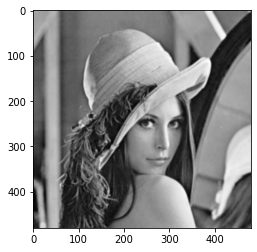

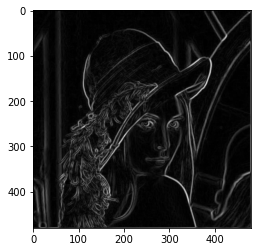

In [31]:
 %matplotlib inline
from datetime import datetime

tiempo_total_CPU = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image 

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------


img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 

  
# Optengo las proporsiones de la imagen. 
img_ancho, img_alto = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

plt.figure()
imgplot=plt.imshow( img_pic_cpu ,cmap="gray")

tiempo_img_CPU = datetime.now()

sobelx = numpy.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = numpy.float)
sobely = numpy.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = numpy.float)

#mitadN = int(img_alto/2)
N = img_alto
M = img_ancho

row = img_alto
column = img_ancho


image = numpy.pad(image, (1,1), 'edge')

for i in range(1, N-1):
#for i in range(mitadN, N-1):
    for j in range(1, M-1):        
        #Calculate gx and gy using Sobel (horizontal and vertical gradients)
        gx = (sobelx[0][0] * image[i-1][j-1]) + (sobelx[0][1] * image[i-1][j]) + \
             (sobelx[0][2] * image[i-1][j+1]) + (sobelx[1][0] * image[i][j-1]) + \
             (sobelx[1][1] * image[i][j]) + (sobelx[1][2] * image[i][j+1]) + \
             (sobelx[2][0] * image[i+1][j-1]) + (sobelx[2][1] * image[i+1][j]) + \
             (sobelx[2][2] * image[i+1][j+1])

        gy = (sobely[0][0] * image[i-1][j-1]) + (sobely[0][1] * image[i-1][j]) + \
             (sobely[0][2] * image[i-1][j+1]) + (sobely[1][0] * image[i][j-1]) + \
             (sobely[1][1] * image[i][j]) + (sobely[1][2] * image[i][j+1]) + \
             (sobely[2][0] * image[i+1][j-1]) + (sobely[2][1] * image[i+1][j]) + \
             (sobely[2][2] * image[i+1][j+1])     

    

        #Calculate the gradient magnitude
        g =numpy.sqrt(gx * gx + gy * gy)
        img_pic_cpu[i-1][j-1] = g




tiempo_img_CPU = datetime.now() - tiempo_img_CPU

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_pic_cpu,cmap="gray" )

tiempo_total_CPU = datetime.now() - tiempo_total_CPU

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img_CPU   ), "[ms]" )
print( "Tiempo Total CPU:",                   tiempo_en_ms( tiempo_total_CPU ), "[ms]" )

---
#4.Métricas

In [ ]:
print( "Tiempo TOTAL CPU  :", tiempo_en_ms( tiempo_total_CPU ), "[ms]" )
print( "Tiempo CPU        :", tiempo_en_ms( tiempo_img_CPU   ), "[ms]\n" )

print("Tiempo TOTAL GPU   : ", tiempo_en_ms( tiempo_total_GPU ), "[ms]" )
print("Tiempo GPU         : ", tiempo_en_ms( tiempo_img_GPU ), "[ms]\n" )


print("SpeedUp            : (tiempo secuencial/tiempo paralelo) : ", tiempo_en_ms(tiempo_total_CPU) , "/" , tiempo_en_ms(tiempo_total_GPU), f"={tiempo_total_CPU/tiempo_total_GPU:,.3f}" )

Tiempo TOTAL CPU  : 5296.418 [ms]
Tiempo CPU        : 5254.135 [ms]

Tiempo TOTAL GPU   :  57.843 [ms]
Tiempo GPU         :  0.223 [ms]

SpeedUp            : (tiempo secuencial/tiempo paralelo) :  5296.418 / 57.843 =91.565


###SpeedUp
Referencia a la ganacia de velocidad que se consigue con un algoritmo paralelo, al resolver el mismo problema con respecto al algoritmo secuencial.

---
#5.Conclusiones

A patir de los casos planteados para  CPU  GPU , podemos observar que el tiempo que tarda en ejectuarse el algorithmon de Soble Filter es menor en el caso de la GPU, esto se debe a que el algoritmo es ejecutado por los hilos de la GPU en forma paralela, y de manera tal que elimina la complijidad computacional de los dos fors que son utilizados en el lagormitmo secuncial para recorrer la imagen utilizada

---
#6.Bibliografía



[1].Winnie Liang (2016,Aug,10).Sobel-Filter-Implementation
Available:[Página web](https://github.com/winniesolves/Sobel-Filter-Implementation/blob/master/Code/custom2Dconvolution.pyhttps://github.com/winniesolves/Sobel-Filter-Implementation/blob/master/Code/custom2Dconvolution.py)

[2].Dr. Abdulsattar M. Khidhir, Nawal Younis Abdullah(2013,Jun-Jul).FPGA Based Edge Detection Using Modified Sobel Filter
Available: [Página web](https://www.academia.edu/4405559/FPGA_Based_Edge_Detection_Using_Modified_Sobel_Filter)

[3].[GPU](https://stackoverflow.com/questions/17815687/image-processing-implementing-sobel-filter/17829869)

[4]. [GPU](https://stackoverflow.com/questions/10798335/cuda-2d-convolution-kernel)

[7]. [GPU](https://stackoverflow.com/questions/45047672/sobel-filter-algorithm-c-no-libraries)

[5]. wvaliente(2021,Jun,27).Prueba 2 - Imagen - CPU.ipynb [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb)

[6]. wvaliente(2021,Jun,27).Prueba 2 - Imagen - GPU.ipynb [Página web](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20GPU.ipynb)

